In [1]:
## Please remember to update "COT.py" to the newest version

import sys
sys.path.append("./")

from COT import COT

In [2]:
## Download GSE28490

import GEOparse

gse = GEOparse.get_GEO(geo="GSE28490", destdir="./", silent=True)

C:\Users\Minta\Anaconda3\lib\site-packages\GEOparse\GEOparse.py:110: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath, open_kwargs=open_kwargs)


In [3]:
## Select needed cell types

cellTypes = {"Neutrophils": [], "NK": [], "CD19+ B": [], "CD8+ T": [], "CD14+ monocytes": []}

sampleType = [] # cell type labels
for cell in cellTypes:
    for gsm in gse.phenotype_data.index.values:
        if cell in gse.phenotype_data["source_name_ch1"][gsm]:
            cellTypes[cell].append(gsm)
            sampleType.append(cell)
            
samples = [] # sample ID
for cell in cellTypes:
    samples = samples + cellTypes[cell]   
    
data = gse.pivot_samples('VALUE')[samples] # selected raw data

In [4]:
## Run COT

cot = COT(df_raw=data, logarithmic_data=True)
cot.generate_subtype_means(sampleType)
cot.generate_cos_values()

COT: package initiated.
COT: subtype means generated.


C:\Users\Minta\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


COT: cos values generated.


In [5]:
## Estimate p-value

cot.estimate_p_values()

COT: estimating p-values ...
Iteration 1: 13.4843 seconds
Iteration 2: 11.8523 seconds
Iteration 3: 12.8031 seconds
Iteration 4: 12.6011 seconds
Iteration 5: 10.6348 seconds
Iteration 6: 10.4281 seconds
COT: p-values estimated.


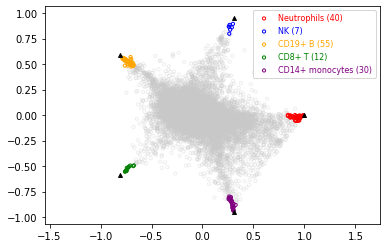

In [6]:
## Plot the markers on the simplex

cot.obtain_subtype_markers(top=144)
cot.plot_simplex()

In [9]:
cot.df_cos["p.value.0"] = cot.df_cos["p.value"]
cot.df_cos["q.value.0"] = cot.df_cos["q.value"]

cot.df_cos

,cos,subtype,p.value,q.value,p.value.0,q.value.0
ID_REF,,,,,,
1007_s_at,0.782502,CD19+ B,0.133469,0.805223,0.133469,0.805223
117_at,0.974535,Neutrophils,0.002672,0.107157,0.002672,0.107157
121_at,0.682464,Neutrophils,0.298165,0.918297,0.298165,0.918297
1294_at,0.628824,CD19+ B,0.462998,0.950758,0.462998,0.950758
1316_at,0.659160,CD8+ T,0.360729,0.938802,0.360729,0.938802
...,...,...,...,...,...,...
AFFX-HUMGAPDH/M33197_5_at,0.794102,CD14+ monocytes,0.120607,0.777834,0.120607,0.777834
AFFX-HUMGAPDH/M33197_M_at,0.809013,CD14+ monocytes,0.104846,0.746175,0.104846,0.746175
AFFX-HUMISGF3A/M97935_3_at,0.526827,CD8+ T,0.901405,0.998092,0.901405,0.998092


In [11]:
data = cot.df_cos['cos'].values.copy()

data

array([0.78250203, 0.97453497, 0.68246415, ..., 0.52682654, 0.61604251,
       0.5671593 ])

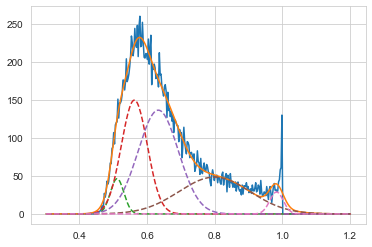

In [14]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline



def norm(x):
    return np.exp(-x**2 / 2) / np.sqrt(2*np.pi)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = np.abs(params[i])
        u = params[i+1]
        s = np.abs(params[i+2]) + 0.02
        y = y + a / s * norm((x - u) / s)
    return y

def func_sep(x, *params):
    y = np.zeros_like(x)
    z = np.zeros((len(params) // 3, len(x)))
    for i in range(0, len(params), 3):
        a = np.abs(params[i])
        u = params[i+1]
        s = np.abs(params[i+2]) + 0.02
        z[i//3, :] = a / s * norm((x - u) / s)
        y = y + z[i//3, :]
    return y, z

guess = np.array([50, 0.50, 0.1, 
                  20, 0.60, 0.1, 
                  20, 0.70, 0.1])
guess = np.array([15, 0.53, 0.01, 
                  30, 0.58, 0.02, 
                  40, 0.65, 0.05, 
                  20, 0.82, 0.07, 
                   3, 0.98, 0.00])
guess = np.array([ 8, 0.53, 0.01, 
                  15, 0.58, 0.02, 
                  20, 0.65, 0.05, 
                  10, 0.82, 0.07, 
                   2, 0.98, 0.00])

bins = np.arange(0.300, 1.205, 0.0025)
cent = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
hist, _ = np.histogram(data, bins=bins)

x = cent
y = hist

popt, pcov = curve_fit(func, x, y, p0=guess, ftol=1e-6)
yfit, ysep = func_sep(x, *popt)
#yfit, ysep = func_sep(x, *guess)

plt.plot(x, y)
plt.plot(x, yfit)
plt.plot(x, ysep.T, '--')

In [15]:
from scipy.special import erf

import random
random.seed(42)

# integral of norm function from +inf to x
def norm_int(x):
    return (1 - erf(x / np.sqrt(2))) / 2 if x >= 0 else (1 + erf(-x / np.sqrt(2))) / 2

# integral of multiple gaussian functions from +inf to x
def p_value(x, params):
    p = 0
    w = 0
    for i in range(0, len(params), 3):
        a = np.abs(params[i])
        u = params[i+1]
        s = np.abs(params[i+2]) + 0.02
        p += a * (norm_int((x - u) / s) - norm_int((1 - u) / s))
        w += a * (norm_int((0 - u) / s) - norm_int((1 - u) / s))
    return p / w

def remove_tp(data, params, alpha=0.05):
    idx_p = [i for i, x in enumerate(data) if p_value(x, params) <= alpha]
    num_fp = int((len(data) - len(idx_p)) / (1 - alpha) * alpha)
    num_tp = len(idx_p) - num_fp
    idx_tp = random.sample(idx_p, num_tp)
    y = np.array([x for i, x in enumerate(data) if i not in set(idx_tp)])
    return y, num_tp

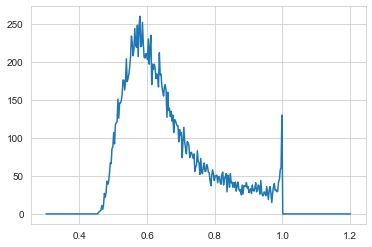

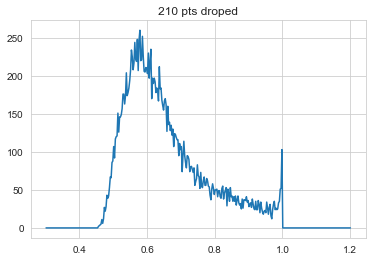

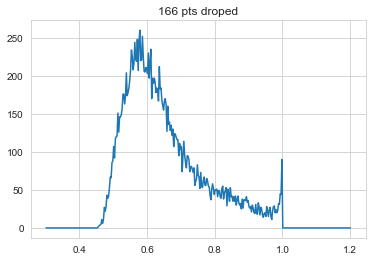

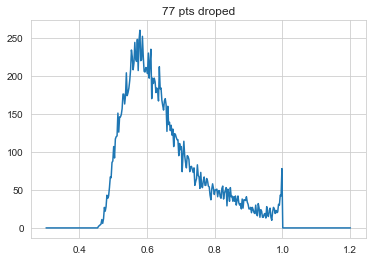

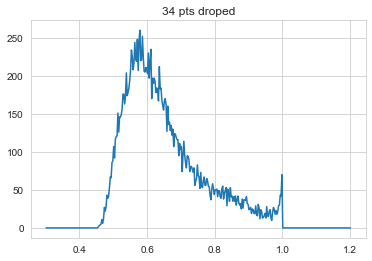

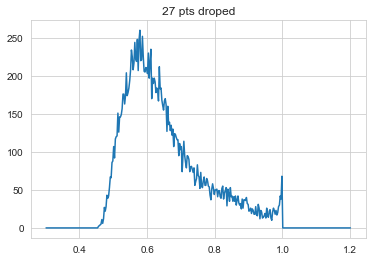

C:\Users\Minta\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


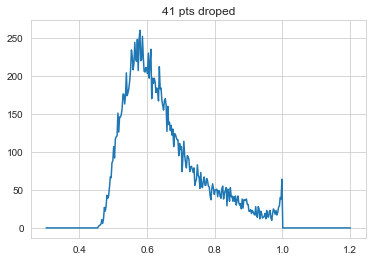

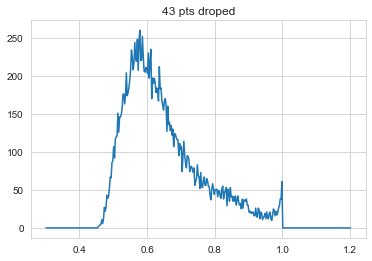

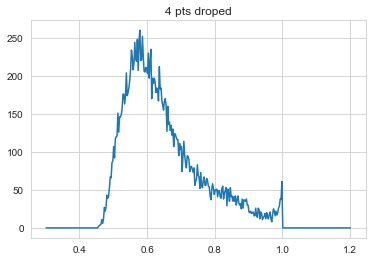

In [19]:
def run_one_iteration(data, bins, guess, alpha=0.05):
    x = np.array([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)])
    y, _ = np.histogram(data, bins=bins)
    
    popt, pcov = curve_fit(func, x, y, p0=guess, ftol=1e-6, maxfev=100000)
    yfit = func(x, *popt)
    
    data_new, num_tp = remove_tp(data, popt, alpha)
    
    return data_new, num_tp, popt

alpha = 0.05
max_iter = 100
threshold_tp = 1

data = cot.df_cos['cos']

x = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
y, _ = np.histogram(data, bins=bins)

fig, ax = plt.subplots()
ax.plot(x, y)

i = 0
fig, ax = plt.subplots()
while True:
    data_new, num_tp, popt = run_one_iteration(data, bins, guess, alpha)
    data = data_new
    guess = popt
    
    i += 1
    if num_tp < threshold_tp or i > max_iter:
        break
    
    y, _ = np.histogram(data, bins=bins)
    
    plt.plot(x, y)
    plt.title(f'{num_tp} pts dropped')
    plt.show()

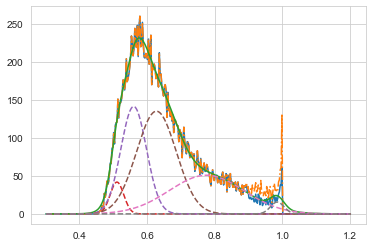

In [21]:
data = cot.df_cos['cos'].values.copy()
yraw, _ = np.histogram(data, bins=bins)

popt, pcov = curve_fit(func, x, y, p0=guess, ftol=1e-6, maxfev=100000)
yfit, ysep = func_sep(x, *popt)

fig, ax = plt.subplots()

ax.plot(x, y)
ax.plot(x, yraw, '-.')
ax.plot(x, yfit)
ax.plot(x, ysep.T, '--')

In [31]:
from statsmodels.stats.multitest import multipletests

cot.df_cos['p.value.1'] = [p_value(x, guess) for x in data]
cot.df_cos['q.value.1'] = multipletests(cot.df_cos['p.value.1'], method='fdr_bh')[1]

In [32]:
cot.df_cos.describe()

,cos,p.value,q.value,p.value.0,q.value.0,p.value.1,q.value.1
count,20367.000000,2.036700e+04,20367.000000,2.036700e+04,20367.000000,20367.000000,20367.000000
mean,0.657950,4.809945e-01,0.874362,4.809945e-01,0.874362,0.484414,0.907217
std,0.124574,2.989550e-01,0.208959,2.989550e-01,0.208959,0.294572,0.148957
min,0.456910,6.263442e-07,0.005550,6.263442e-07,0.005550,0.000004,0.033734
25%,0.566228,2.182838e-01,0.872708,2.182838e-01,0.872708,0.225979,0.903049
50%,0.625087,4.777401e-01,0.955323,4.777401e-01,0.955323,0.483055,0.965209
75%,0.719647,7.369837e-01,0.982124,7.369837e-01,0.982124,0.739543,0.985921
max,0.999990,9.993222e-01,0.999322,9.993222e-01,0.999322,0.997771,0.997771


In [33]:
cot.df_cos["p.value"] = cot.df_cos["p.value.1"]
cot.df_cos["q.value"] = cot.df_cos["q.value.1"]

cot.df_cos

,cos,subtype,p.value,q.value,p.value.0,q.value.0,p.value.1,q.value.1
ID_REF,,,,,,,,
1007_s_at,0.782502,CD19+ B,0.142280,0.858247,0.133469,0.805223,0.142280,0.858247
117_at,0.974535,Neutrophils,0.011563,0.463687,0.002672,0.107157,0.011563,0.463687
121_at,0.682464,Neutrophils,0.302913,0.932800,0.298165,0.918297,0.302913,0.932800
1294_at,0.628824,CD19+ B,0.469121,0.963197,0.462998,0.950758,0.469121,0.963197
1316_at,0.659160,CD8+ T,0.367237,0.955743,0.360729,0.938802,0.367237,0.955743
...,...,...,...,...,...,...,...,...
AFFX-HUMGAPDH/M33197_5_at,0.794102,CD14+ monocytes,0.129726,0.836645,0.120607,0.777834,0.129726,0.836645
AFFX-HUMGAPDH/M33197_M_at,0.809013,CD14+ monocytes,0.114359,0.813846,0.104846,0.746175,0.114359,0.813846
AFFX-HUMISGF3A/M97935_3_at,0.526827,CD8+ T,0.895757,0.992788,0.901405,0.998092,0.895757,0.992788


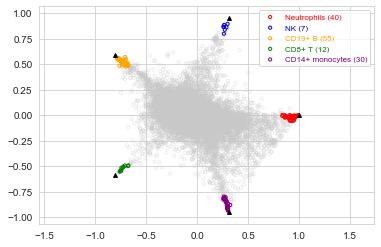

In [41]:
## Plot the markers on the simplex (old plot)

cot.df_cos["p.value"] = cot.df_cos["p.value.0"]
cot.df_cos["q.value"] = cot.df_cos["q.value.0"]

cot.obtain_subtype_markers(qThre=0.05, top=144)
cot.plot_simplex()

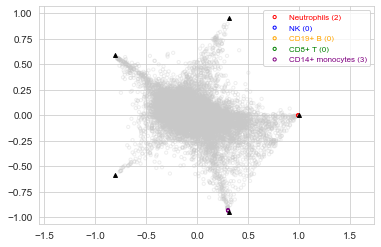

In [43]:
## Plot the markers on the simplex (new plot)

cot.df_cos["p.value"] = cot.df_cos["p.value.1"]
cot.df_cos["q.value"] = cot.df_cos["q.value.1"]

cot.obtain_subtype_markers(qThre=0.05, top=144)
cot.plot_simplex()

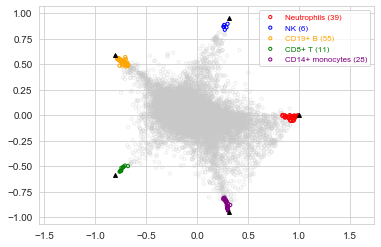

In [45]:
## Plot the markers on the simplex (new plot)

cot.df_cos["p.value"] = cot.df_cos["p.value.1"]
cot.df_cos["q.value"] = cot.df_cos["q.value.1"]

cot.obtain_subtype_markers(qThre=0.15, top=144)
cot.plot_simplex()

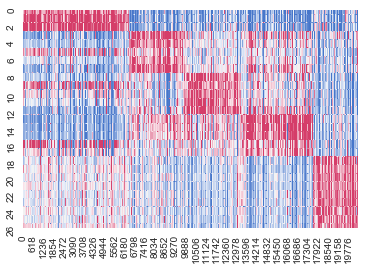

In [88]:
## plot heatmap

import seaborn as sns

order = {v: i for i, v in enumerate(cot.df_mean.columns)}
index = cot.df_cos['subtype'].map(order).sort_values().index
# data = cot.df_raw.loc[index].apply(np.log2).values.T
data = cot.df_raw.loc[index].apply(lambda x: x / np.sum(x), axis=1).values.T

sns.heatmap(data, vmin=0.01, vmax=0.06, cbar=False, cmap=sns.diverging_palette(255, 0, n=100))
# plt.xticks([])
# plt.yticks([])
plt.show()